## Fetching a NEXRAD file and extracting a column

<a href='https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long'> This Stack overflow post </a> Gives a way to get the range and azimuth between two lat lon points. 

For our example here we are going to use the ARM deployment to Houston as an example and extract a column over ARM site at La Porte from the KHGX NEXRAD volume.


In [16]:
import nexradaws
import tempfile
import os
import shutil
import pyart
import pytz
import pyproj
from datetime import datetime, timedelta

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np


In [11]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = tlocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

In [12]:
conn = nexradaws.NexradAwsInterface()
recent_time = datetime(2021, 9, 29, 12, 0, 0).replace(tzinfo=pytz.UTC)

my_radar = get_my_radar(conn, 'KHGX', recent_time)

145 145
Downloaded KHGX20210929_115715_V06
1 out of 1 files downloaded...0 errors


Lets check the location of our radar!

In [14]:
print(my_radar.longitude)
print(my_radar.latitude)


{'long_name': 'Longitude', 'standard_name': 'Longitude', 'units': 'degrees_east', 'data': array([-95.07873535])}
{'long_name': 'Latitude', 'standard_name': 'Latitude', 'units': 'degrees_north', 'data': array([29.47190094])}


/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/Users/scollis/miniconda3/envs/pyart-training/lib/python3.7/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

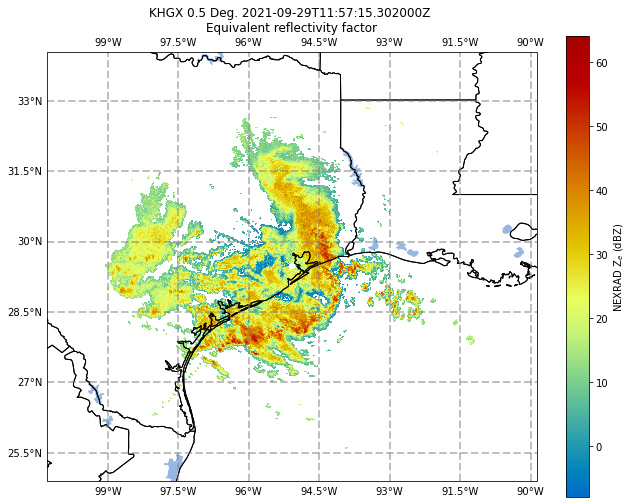

In [18]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(my_radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)